In [53]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2
from skimage import io
import pandas as pd
from PIL import Image

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla T4


In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9673 sha256=732d3e092823c926cc28872824dbcce4eee59792712cd1a7f60c660deb7a7ce2
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [5]:
import wget
url = 'https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv'
filename = wget.download(url)

In [8]:
url = 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv'
filename = wget.download(url)

In [6]:
url = 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv'
filename = wget.download(url)

In [9]:
images_boxable_file = '/content/drive/MyDrive/Colab Notebooks/Object Detection/train-images-boxable-with-rotation.csv' # image name and url
annotations_bbox_file = '/content/drive/MyDrive/Colab Notebooks/Object Detection/train-annotations-bbox.csv' # bounding box, coordinates
class_descriptions_file = '/content/drive/MyDrive/Colab Notebooks/Object Detection/class-descriptions-boxable.csv' #class name

In [12]:
images_boxable = pd.read_csv(images_boxable_file) # image name and url
images_boxable.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
0,4fa8054781a4c382,train,https://farm3.staticflickr.com/5310/5898076654...,https://www.flickr.com/photos/michael-beat/589...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/michael-beat/,Michael Beat,...die FNF-Kerze,4405052,KFukvivpCM5QXl5SqKe41g==,https://c1.staticflickr.com/6/5310/5898076654_...,0.0
1,b37f763ae67d0888,train,https://c1.staticflickr.com/1/67/197493648_628...,https://www.flickr.com/photos/drstarbuck/19749...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/drstarbuck/,Karen,Three boys on a hill,494555,9IzEn38GRNsVpATuv7gzEA==,https://c3.staticflickr.com/1/67/197493648_628...,0.0
2,7e8584b0f487cb9e,train,https://c7.staticflickr.com/8/7056/7143870979_...,https://www.flickr.com/photos/circasassy/71438...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/circasassy/,CircaSassy,A Christmas carol and The cricket on the heart...,2371584,3hQwu0iSzY1VIoXiwp0/Mg==,https://c7.staticflickr.com/8/7056/7143870979_...,0.0
3,86638230febe21c4,train,https://farm5.staticflickr.com/5128/5301868579...,https://www.flickr.com/photos/ajcreencia/53018...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/ajcreencia/,Alex,Abbey and Kenny,949267,onB+rCZnGQg5PRX7xOs18Q==,https://c4.staticflickr.com/6/5128/5301868579_...,NaN
4,249086e72671397d,train,https://c6.staticflickr.com/4/3930/15342460029...,https://www.flickr.com/photos/codnewsroom/1534...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/codnewsroom/,COD Newsroom,Suburban Law Enforcement Academy 20th Annivers...,6541758,MjpaAVbMAWbCusSaxI1D7w==,https://c1.staticflickr.com/4/3930/15342460029...,0.0


In [13]:
annotations_bbox = pd.read_csv(annotations_bbox_file) # bounding box, coordinates, occluded means blocled
annotations_bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


In [14]:
class_descriptions = pd.read_csv(class_descriptions_file, header=None) #class name
class_descriptions.head()

,0,1
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [15]:
# Code for plotting bounding box
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

Image: (2125, 3000, 3)
Coordinates: (1891, 1485), (2086, 1914)
Coordinates: (2514, 170), (2940, 622)
Coordinates: (1395, 1427), (1625, 1931)
Coordinates: (1636, 1447), (1886, 1928)
Coordinates: (2216, 1462), (2358, 1843)
Coordinates: (0, 0), (2998, 2123)
Coordinates: (0, 1072), (213, 2123)
Coordinates: (556, 1318), (1175, 1922)
Coordinates: (660, 127), (1121, 502)
Coordinates: (1674, 198), (2098, 538)
Coordinates: (1756, 1303), (2075, 1868)
Coordinates: (2570, 1288), (2998, 1845)


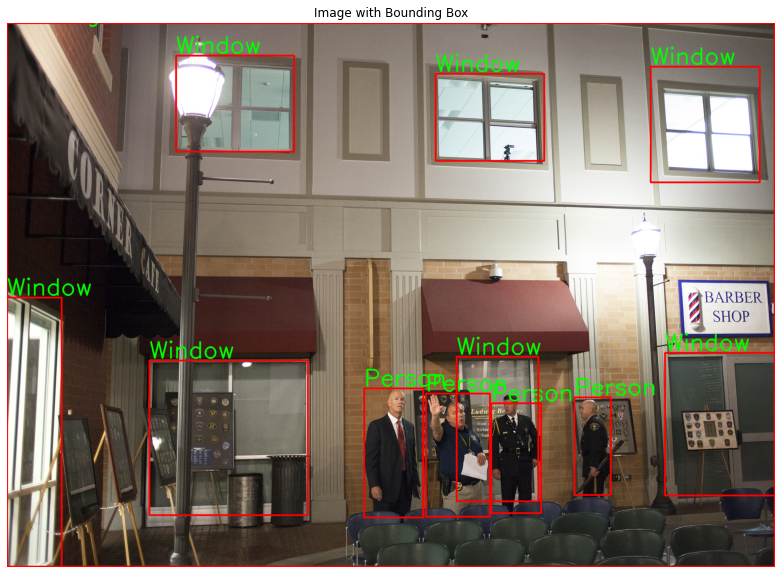

In [24]:
plot_bbox('249086e72671397d')

In [29]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

for img_id in random.sample(list(least_objects_img_ids), 3):
  plot_bbox(img_id)

Output hidden; open in https://colab.research.google.com to view.

In [64]:
#among 600 classes choose 3/4
class_descriptions[1].count()

601

In [65]:
# Find the label_name for 'Bed', 'Chair' and 'Table' classes
bed_pd = class_descriptions[class_descriptions[1]=='Bed']
chair_pd = class_descriptions[class_descriptions[1]=='Chair']
table_pd = class_descriptions[class_descriptions[1]=='Table']

print(bed_pd)
#print(chair_pd)

             0    1
257  /m/03ssj5  Bed


In [66]:
label_name_bed = bed_pd[0].values[0]
label_name_chair = chair_pd[0].values[0]
label_name_table = table_pd[0].values[0]

label_name_bed

'/m/03ssj5'

In [67]:
bed_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_bed]
chair_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_chair]
table_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_table]

bed_bbox

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
5953,00041cc3701f7805,xclick,/m/03ssj5,1,0.135112,0.366609,0.420573,0.625000,1,0,0,0,0
5954,00041cc3701f7805,xclick,/m/03ssj5,1,0.179862,0.405336,0.436198,0.856771,0,0,0,0,0
9974,00074503ceae5131,xclick,/m/03ssj5,1,0.000000,0.999375,0.000000,0.999062,1,1,0,0,0
13671,000a54f1bdb96839,xclick,/m/03ssj5,1,0.000000,0.999167,0.028125,0.999375,0,1,0,0,0
17469,000da932ca7e68e4,xclick,/m/03ssj5,1,0.000000,0.753125,0.328330,0.993433,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14585203,ff7f55b7f6794f63,xclick,/m/03ssj5,1,0.000000,0.999375,0.000000,0.997500,1,1,0,0,0
14595452,ffb716498f082103,xclick,/m/03ssj5,1,0.180000,0.998750,0.309568,0.998124,0,0,0,0,0
14600295,ffce182988b6b746,xclick,/m/03ssj5,1,0.000000,0.305625,0.707317,0.999062,0,1,0,0,0
14602507,ffd718211ba34626,activemil,/m/03ssj5,1,0.006250,0.207500,0.373333,0.805000,1,1,0,0,0


In [68]:
print('There are %d beds in the dataset' %(len(bed_bbox)))
print('There are %d chairs in the dataset' %(len(chair_bbox)))
print('There are %d tables in the dataset' %(len(table_bbox)))

There are 3563 beds in the dataset
There are 132483 chairs in the dataset
There are 85691 tables in the dataset


In [69]:
bed_img_id = bed_bbox['ImageID']
chair_img_id = chair_bbox['ImageID']
table_img_id = table_bbox['ImageID']
bed_img_id

5953        00041cc3701f7805
5954        00041cc3701f7805
9974        00074503ceae5131
13671       000a54f1bdb96839
17469       000da932ca7e68e4
                  ...       
14585203    ff7f55b7f6794f63
14595452    ffb716498f082103
14600295    ffce182988b6b746
14602507    ffd718211ba34626
14602925    ffd95054b5fa8ba3
Name: ImageID, Length: 3563, dtype: object

In [92]:
# working on 10 images
n = 10
subbed_img_id = random.sample(list(bed_img_id), n)
subchair_img_id = random.sample(list(chair_img_id), n)
subtable_img_id = random.sample(list(table_img_id), n)
subbed_img_id

['2b8d364cae839299',
 '3c76bbf69f813a07',
 'cc5354f895de66d9',
 'bb564bebb593416b',
 '925d4105691454ad',
 '9f78cb387c706bd3',
 'cf21aabdc3dcc244',
 'c8c121caa9865e38',
 '9ee9215dda95ab48',
 '09605668fa4c0467']

In [85]:
subbed_pd = images_boxable.loc[images_boxable['ImageID'].isin(subbed_img_id)]
subchair_pd = images_boxable.loc[images_boxable['ImageID'].isin(subchair_img_id)]
subtable_pd = images_boxable.loc[images_boxable['ImageID'].isin(subtable_img_id)]

subbed_pd

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
189180,eb0e76f30d831748,train,https://c1.staticflickr.com/5/4118/4819740520_...,https://www.flickr.com/photos/midiman/4819740520,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/midiman/,midiman,IMG_0814,3760445,JqXTRWbMMFooPsIj0zjSmw==,https://c1.staticflickr.com/5/4118/4819740520_...,0.0
266877,484ac764157b5838,train,https://c1.staticflickr.com/9/8330/8097784851_...,https://www.flickr.com/photos/twak/8097784851,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/twak/,twak,Greenleaf Guesthouse &quot;Pak Chong&quot;,5935344,YAWkHpAvZt3rTs++GvT7Yw==,https://c5.staticflickr.com/9/8330/8097784851_...,0.0
347213,43c8781370970680,train,https://farm1.staticflickr.com/166/388358513_3...,https://www.flickr.com/photos/fimbrethil/38835...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/fimbrethil/,Fimb,Where?,2160252,kqFCMH6EUVgeNMH7IVC6Cw==,https://c5.staticflickr.com/1/166/388358513_31...,0.0
778464,72dceae04df5f54c,train,https://c5.staticflickr.com/6/5583/15041461126...,https://www.flickr.com/photos/cdcglobal/150414...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/cdcglobal/,CDC Global,New isolation ward,44867,+VxQtWKqh1xVJWdXIcuGaQ==,https://c8.staticflickr.com/6/5583/15041461126...,0.0
780652,efaba411b2107bbc,train,https://c5.staticflickr.com/9/8077/8418303276_...,https://www.flickr.com/photos/73577218@N00/841...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/73577218@N00/,Mr. Littlehand,Lorraine Motel Martin Luther King room 306 3,1860420,GUed9cMbio3MiHFW7JwSRg==,https://c1.staticflickr.com/9/8077/8418303276_...,0.0
1111133,dbeea9950d39d1b4,train,https://farm5.staticflickr.com/8422/7768923828...,https://www.flickr.com/photos/tinfoilraccoon/7...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/tinfoilraccoon/,rochelle hartman,Springbrook State Park Dorm,206069,qOPn/k2F1++BvTACeOSXUg==,https://c7.staticflickr.com/9/8422/7768923828_...,0.0
1159898,0237d2ec84e30886,train,https://farm7.staticflickr.com/2680/4479487834...,https://www.flickr.com/photos/calculat0r/44794...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/calculat0r/,Jeremy Gordon,Untitled,179908,chfs/83KVaCUdBYDjKsWxA==,https://c6.staticflickr.com/3/2680/4479487834_...,0.0
1317665,054c7da0d43116c6,train,https://farm7.staticflickr.com/8028/7152681207...,https://www.flickr.com/photos/bizmac/7152681207/,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/bizmac/,bizmac,IMG_0482.JPG,9411747,TEXVeYreZqor7+CzElFZEA==,https://c6.staticflickr.com/9/8028/7152681207_...,0.0
1432632,cfc18e4514d7f135,train,https://farm6.staticflickr.com/3727/9487941622...,https://www.flickr.com/photos/100113435@N03/94...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/100113435@N03/,Hotel Stationery,Bedroom 03,1678560,QYf5RFYup4LbqOzEQSXcmg==,https://c3.staticflickr.com/4/3727/9487941622_...,0.0
1729236,2eac61affad7a76d,train,https://c6.staticflickr.com/8/7484/15701188666...,https://www.flickr.com/photos/portobaytrade/15...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/portobaytrade/,PortoBay Hotels &amp; Resorts,L'HOTEL PORTO BAY SÃO PAULO | honeymoon setup,7278846,BFV1Z+DiX7XX3VPTwx+WKg==,https://c4.staticflickr.com/8/7484/15701188666...,0.0


In [93]:
subbed_dict = subbed_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subchair_dict = subchair_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subtable_dict = subtable_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

subbed_dict

{'0237d2ec84e30886': 'https://farm7.staticflickr.com/2680/4479487834_489d670301_o.jpg',
 '054c7da0d43116c6': 'https://farm7.staticflickr.com/8028/7152681207_13249e19c9_o.jpg',
 '2eac61affad7a76d': 'https://c6.staticflickr.com/8/7484/15701188666_b0a68100d7_o.jpg',
 '43c8781370970680': 'https://farm1.staticflickr.com/166/388358513_317ec774b0_o.jpg',
 '484ac764157b5838': 'https://c1.staticflickr.com/9/8330/8097784851_70c67de2da_o.jpg',
 '72dceae04df5f54c': 'https://c5.staticflickr.com/6/5583/15041461126_41be2288be_o.jpg',
 'cfc18e4514d7f135': 'https://farm6.staticflickr.com/3727/9487941622_54c58c8253_o.jpg',
 'dbeea9950d39d1b4': 'https://farm5.staticflickr.com/8422/7768923828_210ae4bae3_o.jpg',
 'eb0e76f30d831748': 'https://c1.staticflickr.com/5/4118/4819740520_f672b2e6c3_o.jpg',
 'efaba411b2107bbc': 'https://c5.staticflickr.com/9/8077/8418303276_ca829b964e_o.jpg'}

In [94]:
mappings = [subbed_dict, subchair_dict, subtable_dict]

In [95]:
classes = ['Bed', 'Chair', 'Table']

In [96]:
# download images in folders(Bed, Chair and table folder with 10 images each)

pth ='/content/drive/MyDrive/Colab Notebooks/Object Detection/'

for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(pth+obj_type):
    os.mkdir(pth+obj_type)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(pth+obj_type, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 1
Images Issues: 1
Images Issues: 0


### Dataset format for Faster-RCNN code
#### (fname_path, xmin, xmax, ymin, ymax, class_name)

In [97]:
# save images to train and test directory, so create 2 folders
train_path = pth + 'train'
test_path = pth + 'test'

In [99]:
# from shutil import copyfile
# for i in range(len(classes)):
#     all_imgs = os.listdir(classes[i])
#     all_imgs = [f for f in all_imgs if not f.startswith('.')]
#     random.shuffle(all_imgs)
    
#     limit = int(n*0.8) # 80% data for training and 20% for testing

#     train_imgs = all_imgs[:limit]
#     test_imgs = all_imgs[limit:]
    
    
#     for j in range(len(train_imgs)):
#         original_path = os.path.join(classes[i], train_imgs[j])
#         new_path = os.path.join(train_path, train_imgs[j])
#         copyfile(original_path, new_path)
    

#     for j in range(len(test_imgs)):
#         original_path = os.path.join(classes[i], test_imgs[j])
#         new_path = os.path.join(test_path, test_imgs[j])
#         copyfile(original_path, new_path)

In [100]:
train_img_count = os.listdir(train_path)
print("Number of images in train found: ", len(train_img_count))

Number of images in train found:  23


In [101]:
test_img_count = os.listdir(test_path)
print("Number of images in test found: ", len(test_img_count))

Number of images in test found:  5


In [ ]:
# diff : creat df of coords

In [103]:
import sys

label_names = [label_name_bed, label_name_chair, label_name_table]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [104]:
train_df

,FileName,XMin,XMax,YMin,YMax,ClassName
0,eb0e76f30d831748.jpg,0.079375,0.959375,0.674484,0.999062,Bed
1,43c8781370970680.jpg,0.168856,0.402439,0.565000,0.999375,Bed
2,72dceae04df5f54c.jpg,0.701434,0.998696,0.457391,0.836522,Bed
3,72dceae04df5f54c.jpg,0.000000,0.216428,0.824348,0.998261,Bed
4,72dceae04df5f54c.jpg,0.000000,0.301173,0.502609,0.848696,Bed
...,...,...,...,...,...,...
216,041bca8dc8c92257.jpg,0.312500,0.555664,0.607353,0.925000,Table
217,5e3ad75ded4f8837.jpg,0.245033,0.521523,0.563275,0.913151,Table
218,5e3ad75ded4f8837.jpg,0.521523,0.587748,0.339950,0.414392,Table
219,5e3ad75ded4f8837.jpg,0.844371,0.947020,0.394541,0.478908,Table


Image: (3168, 4752, 3)
Coordinates: (377, 2136), (4558, 3165)


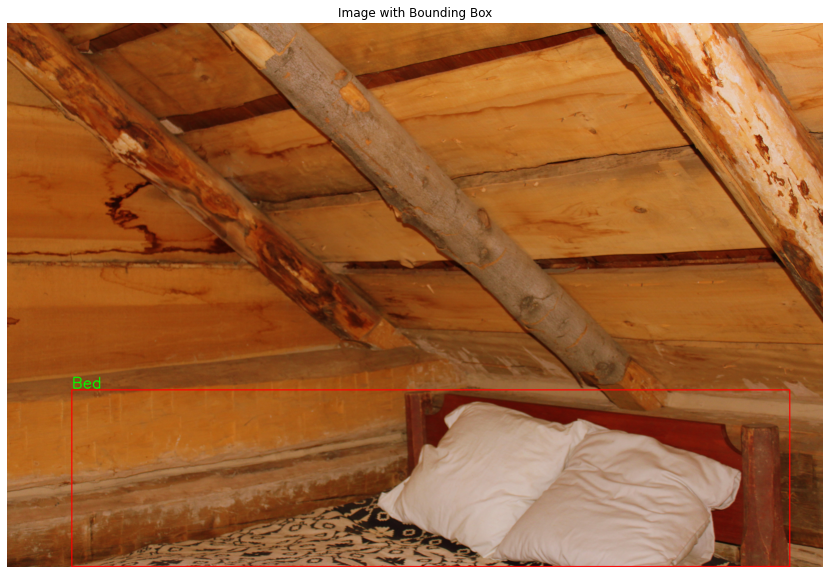

Image: (3888, 2592, 3)
Coordinates: (158, 651), (1706, 3841)
Coordinates: (2010, 0), (2589, 3885)
Coordinates: (437, 2196), (1043, 3885)


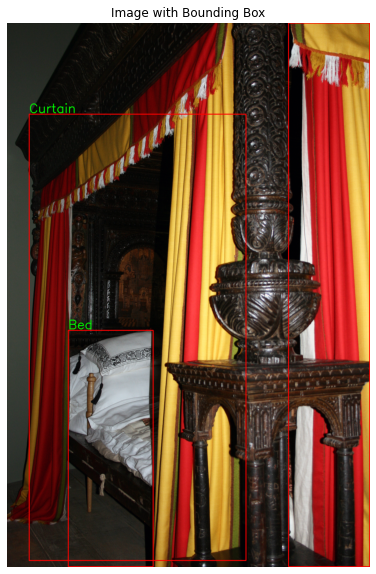

Image: (575, 767, 3)
Coordinates: (537, 262), (765, 481)
Coordinates: (0, 474), (166, 574)
Coordinates: (0, 289), (230, 488)
Coordinates: (0, 189), (253, 357)
Coordinates: (75, 177), (274, 299)
Coordinates: (129, 170), (276, 283)
Coordinates: (165, 167), (291, 257)
Coordinates: (407, 175), (489, 220)
Coordinates: (412, 184), (535, 276)
Coordinates: (417, 183), (600, 297)
Coordinates: (457, 192), (722, 353)


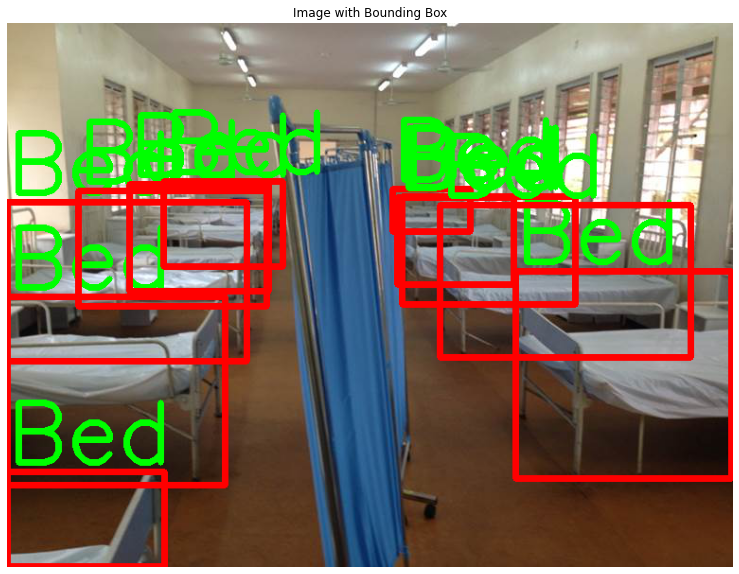

In [105]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique() # plotting the bounding box
for img_id in train_img_ids:
  plot_bbox(img_id)

In [106]:
val_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                val_df = val_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [109]:
val_df.head()

,FileName,XMin,XMax,YMin,YMax,ClassName
0,efaba411b2107bbc.jpg,0.000000,0.829167,0.271250,0.501875,Bed
1,efaba411b2107bbc.jpg,0.000000,0.999167,0.460625,0.998750,Bed
2,ac048d75452d06fc.jpg,0.653750,0.956875,0.591667,0.908333,Table
3,ac048d75452d06fc.jpg,0.164375,0.197500,0.541667,0.617500,Chair
4,ac048d75452d06fc.jpg,0.175625,0.232500,0.484167,0.617500,Chair


In [111]:
train_df.to_csv(pth+'train.csv')
val_df.to_csv(pth+'test.csv')

In [114]:
# #Write train.csv to annotation.txt

# train_df = pd.read_csv(pth+'train.csv')

# # for training
# with open("annotation.txt", "w+") as f:
#   for idx, row in train_df.iterrows():
#       img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Object Detection/train' + row['FileName'])
#       height, width = img.shape[:2]
#       x1 = int(row['XMin'] * width)
#       x2 = int(row['XMax'] * width)
#       y1 = int(row['YMin'] * height)
#       y2 = int(row['YMax'] * height)
      
#       train_file_path = train_path
#       fileName = os.path.join(train_file_path, row['FileName'])
#       className = row['ClassName']
#       f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [115]:

test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread('test/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      test_file_path = 'D:/5-deep_learning_with_tensorflow/module 7 cnn/7-faster_r-cnn/Faster_r-cnn_demo_youtube/test'
      fileName = os.path.join(test_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

AttributeError: ignored